## Кейс №1 - Приложение знакомств

In [35]:
from scipy.stats import bootstrap

import pandas as pd
import numpy as np
import seaborn as sns

import plotly.express as px
import pingouin as pg

import scipy.stats as stats
from scipy.stats import chi2_contingency

sns.set(rc={'figure.figsize':(12,6)}, style="whitegrid")

In [6]:
df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-e-soloveva/Статистика/dating_data.csv')

In [7]:
df

,user_id_1,user_id_2,group,is_match
0,79,91,1,1
1,716,353,1,1
2,423,677,0,0
3,658,165,1,1
4,969,155,0,1
...,...,...,...,...
14509,476,631,0,0
14510,455,770,1,0
14511,260,6,1,1
14512,885,812,1,1


In [8]:
df.shape

(14514, 4)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14514 entries, 0 to 14513
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   user_id_1  14514 non-null  int64
 1   user_id_2  14514 non-null  int64
 2   group      14514 non-null  int64
 3   is_match   14514 non-null  int64
dtypes: int64(4)
memory usage: 453.7 KB


In [10]:
df.isnull().sum()

user_id_1    0
user_id_2    0
group        0
is_match     0
dtype: int64

На основе таблицы можем определить, что тип данных переменных `group` и `is_match` относится к категориальным (качественным, дискретным), следовательно, для последующего анализа будем использовать критерий **Хи-квадрат**.

In [11]:
#Определим размер каждой группы
df.groupby('group').agg({'is_match':'count'})

,is_match
group,
0,4792
1,9722


In [12]:
df.group.value_counts()

1    9722
0    4792
Name: group, dtype: int64

In [13]:
df.is_match.value_counts()

0    9671
1    4843
Name: is_match, dtype: int64

In [76]:
test = df[df.group == 1]
test

,user_id_1,user_id_2,group,is_match
0,79,91,1,1
1,716,353,1,1
3,658,165,1,1
6,435,16,1,0
7,602,327,1,0
...,...,...,...,...
14508,527,647,1,0
14510,455,770,1,0
14511,260,6,1,1
14512,885,812,1,1


In [77]:
control = df[df.group == 0]
control

,user_id_1,user_id_2,group,is_match
2,423,677,0,0
4,969,155,0,1
5,227,162,0,0
8,223,295,0,0
10,825,388,0,0
...,...,...,...,...
14502,535,545,0,0
14503,128,268,0,0
14505,544,600,0,0
14506,903,505,0,0


In [247]:
control_df = control.groupby(['user_id_1'])\
                    .agg({'is_match':['sum', 'count']})\
                    .reset_index()\
                    .rename(columns={'sum':'match_sum', 'count':'count_match'})
control_df.columns = [tup[1] if tup[1] else tup[0] for tup in control_df.columns]
control_df

,user_id_1,match_sum,count_match
0,4,2,9
1,10,3,6
2,12,1,12
3,14,0,8
4,15,3,20
...,...,...,...
496,994,2,9
497,995,2,8
498,996,1,8
499,997,1,12


In [250]:
test_df = test.groupby(['user_id_1'])\
              .agg({'is_match':['sum', 'count']})\
              .reset_index()\
              .rename(columns={'sum':'match_sum', 'count':'count_match'})
test_df.columns = [tup[1] if tup[1] else tup[0] for tup in test_df.columns]
test_df

,user_id_1,match_sum,count_match
0,1,11,24
1,2,7,16
2,3,5,16
3,5,13,22
4,6,9,22
...,...,...,...
494,987,8,23
495,992,8,21
496,993,6,18
497,998,10,18


Исходя из размерности наших групп, мы можем заметить, что после группировки на пользователей в каждой группе, размерности стали приблизительно равны, то есть можем работать с подготовленными данными.

## Выбор метрики
Поскольку нам необходимо оценить, правда ли, что новый алгоритм улучшил качество сервиса. Будем использовать метрику **соотношения кол-ва мэтчей (1) у пользователя к общему кол-ву мэтчей (1 И 0) у пользователя**, то есть отношение мэтчей у пользователя, к числу общего кол-ва совершённых операций, так мы рассмотрим показатель динамики мэтчей у пользователей, насколько оно возросло/уменьшилось.

Сгруппируем наш датасет по номеру группы и посчитаем выбранную метрику.

In [148]:
pd.crosstab(df.is_match, df.group)

group,0,1
is_match,,
0,3858,5813
1,934,3909


In [303]:
df_grouped = df.groupby('group')\
               .agg({'user_id_1':'count', 'is_match': 'sum'})\
               .rename(columns={'user_id_1' : 'user'})
df_grouped

,user,is_match
group,,
0,4792,934
1,9722,3909


In [177]:
df_grouped['conversion'] = (df_grouped['is_match'] / df_grouped['user'])*100
df_grouped

,user,is_match,conversion
group,,,
0,4792,934,19.490818
1,9722,3909,40.207776


In [252]:
control_df['match_rate_perc'] = (control_df['match_sum'] / control_df['count_match']) * 100
control_df

,user_id_1,match_sum,count_match,match_rate_perc
0,4,2,9,22.222222
1,10,3,6,50.000000
2,12,1,12,8.333333
3,14,0,8,0.000000
4,15,3,20,15.000000
...,...,...,...,...
496,994,2,9,22.222222
497,995,2,8,25.000000
498,996,1,8,12.500000
499,997,1,12,8.333333


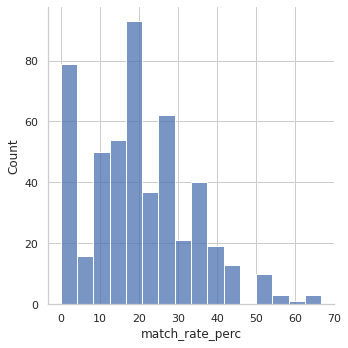

In [253]:
sns.displot(data=control_df, x='match_rate_perc')

In [254]:
test_df['match_rate_perc'] = (test_df['match_sum'] / test_df['count_match']) * 100
test_df

,user_id_1,match_sum,count_match,match_rate_perc
0,1,11,24,45.833333
1,2,7,16,43.750000
2,3,5,16,31.250000
3,5,13,22,59.090909
4,6,9,22,40.909091
...,...,...,...,...
494,987,8,23,34.782609
495,992,8,21,38.095238
496,993,6,18,33.333333
497,998,10,18,55.555556


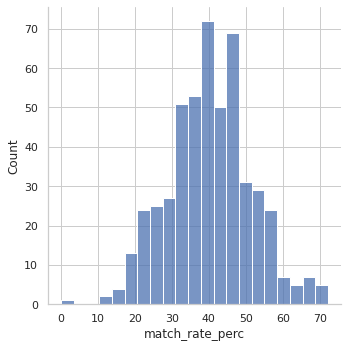

In [255]:
sns.displot(data=test_df, x='match_rate_perc')

Можем заметить, что процент между контрольной группой и тестовой, отличается, где у тестовой процент увеличился.

Учтём статистическую значимость, чтобы удостовериться, что результат теста не оказался случайным.

Найдём взаимосвязь между мэтчами и типом группы.

Используя, Хи-квадрат, поскольку две переменные категориальные.

- $H_0$: взаимосвязи между переменными нет 
- $H_1$: взаимосвязь есть

In [304]:
from scipy.stats import chi2_contingency, chi2 

In [307]:
# Проверим результат с помощью statsmodels
stat, p, dof, expected = chi2_contingency(pd.crosstab(df.is_match, df.group))

In [308]:
stat, p, dof, expected 

(618.6889141576197,
 1.441829916366341e-136,
 1,
 array([[3193.01584677, 6477.98415323],
        [1598.98415323, 3244.01584677]]))

In [309]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Отклоняем H0


Следовательно, нулевая гипотеза отклоняется и принимается альтернативная, что **взаимосвязь между переменными есть**.

Отразим на графике нормализованные значения.

In [310]:
fig = px.histogram(control_df, x='match_rate_perc', histnorm='probability density')
fig.show()

In [311]:
fig = px.histogram(test_df, x='match_rate_perc', histnorm='probability density')
fig.show()

Применим методику бутстрапа.

In [312]:
#Для контрольной группы
control_df.sample(frac=1, replace=True)

,user_id_1,match_sum,count_match,match_rate_perc
227,448,1,5,20.000000
7,20,0,7,0.000000
192,384,3,15,20.000000
68,128,6,12,50.000000
418,826,1,8,12.500000
...,...,...,...,...
195,394,0,9,0.000000
372,728,1,4,25.000000
423,837,2,5,40.000000
118,233,3,13,23.076923


In [266]:
medians = []

#повторяем процесс 10000 раз
for i in range(10000):
    sample_data = control_df.sample(frac=1, replace=True)

    sample_median = sample_data.match_rate_perc.median()

    medians.append(sample_median)

In [267]:
medians

[16.666666666666664,
 20.0,
 18.181818181818183,
 17.647058823529413,
 18.181818181818183,
 18.75,
 18.75,
 20.0,
 16.666666666666664,
 16.666666666666664,
 18.181818181818183,
 18.75,
 18.181818181818183,
 17.647058823529413,
 18.181818181818183,
 20.0,
 16.666666666666664,
 18.181818181818183,
 18.181818181818183,
 18.181818181818183,
 18.181818181818183,
 16.666666666666664,
 18.181818181818183,
 16.666666666666664,
 16.666666666666664,
 18.75,
 18.181818181818183,
 18.181818181818183,
 20.0,
 20.0,
 18.181818181818183,
 18.75,
 20.0,
 18.181818181818183,
 18.181818181818183,
 18.181818181818183,
 18.181818181818183,
 16.666666666666664,
 20.0,
 18.181818181818183,
 18.181818181818183,
 18.181818181818183,
 18.181818181818183,
 20.0,
 18.181818181818183,
 20.0,
 18.181818181818183,
 18.181818181818183,
 20.0,
 16.666666666666664,
 18.181818181818183,
 20.0,
 20.0,
 18.181818181818183,
 17.647058823529413,
 20.0,
 18.181818181818183,
 20.0,
 20.0,
 16.666666666666664,
 17.64705882352

In [268]:
pd.Series(medians).quantile(0.025)

16.666666666666664

In [269]:
pd.Series(medians).quantile(0.975)

20.0

In [ ]:
#Общий код для двух групп

In [292]:
median_diff = []

for i in range(10000):
    sample_data_control = control_df.sample(frac=1, replace=True)
    sample_median_control = sample_data_control.match_rate_perc.median()
    
    sample_data_test = test_df.sample(frac=1, replace=True)
    sample_median_test = sample_data_test.match_rate_perc.median()
    
    sample_median_diff = sample_median_control - sample_median_test
    median_diff.append(sample_median_diff)

In [293]:
pd.Series(median_diff).quantile(0.025)

-24.509803921568626

In [294]:
pd.Series(median_diff).quantile(0.975)

-20.0

In [287]:
#Используем метод bootstrap из библиотеки SciPy

In [301]:
stats.bootstrap((test_df.match_rate_perc, ), np.median, method='percentile')

BootstrapResult(confidence_interval=ConfidenceInterval(low=39.130434782608695, high=41.17647058823529), standard_error=0.5629142359918955)

In [302]:
stats.bootstrap((control_df.match_rate_perc, ), np.median, method='percentile')

BootstrapResult(confidence_interval=ConfidenceInterval(low=16.666666666666664, high=20.0), standard_error=1.1062395140205477)

## Вывод


Доверительные интервалы не пересекаются, это значит, что с высокой степенью вероятности средние значения в генеральных совокупностях различны. В этом случае гипотеза о том, что эти средние одинаковы, отклоняется, а различие между выборочными средними считается статистически значимым (т.е. существенным).

Можно сказать, что новый алгоритм сервиса значительно лидирует по показателю соотношения кол-ва мэтчей (1) у пользователя к общему кол-ву мэтчей (1 И 0) у пользователя, конверсия составила у тестовой группы `40,2%`, а у контрольной - `19,49%`. Доверительные интервалы для обеих оценок `(39,13-41,18)` и `(16,67-20,0)` соотвтественно у тестовой и контрольной группы. Таким образом, новый алгоритм положительно повлиял на подбор анкет для пользователь. 